#  Two time correlation - Duke Silica Spehers

## Published in
 L. Li, P. Kwasniewski, D. Oris, L Wiegart, L. Cristofolini,
 C. Carona and A. Fluerasu , "Photon statistics and speckle visibility
 spectroscopy with partially coherent x-rays" J. Synchrotron Rad.,
 vol 21, p 1288-1295, 2014.

In [10]:
from skbeam.core import roi 
import skbeam.core.correlation as corr
from skbeam.core import utils

import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm

## Data

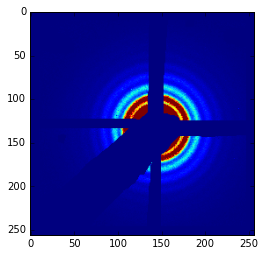

In [3]:
data_dir = "/Volumes/Data/BeamLines/CHX/Luxi_description_files_for_duke/"
duke_ndata = np.load(data_dir+"duke_img_1_5000.npy")
duke_dark = np.load(data_dir+"duke_dark.npy")

duke_data = []
for i in range(duke_ndata.shape[0]):
    duke_data.append(duke_ndata[i] - duke_dark)
    
duke_data = np.asarray(duke_data)    

avg_img = np.average(duke_data, axis=0)

mask4 = np.load(data_dir+"new_mask4.npy")

mask = np.load(data_dir+"Luxi_duke_mask.npy")

N_mask = ~(mask + mask4)

plt.imshow(N_mask*avg_img, vmax=1e0)
plt.show()

#  Mask the data and create a ring mask

In [4]:
mask_data1 = N_mask*duke_data[0:2655]
mask_data2 = N_mask*duke_data[2659:4999]

inner_radius = 24
width = 9
spacing = 1
num_rings = 6

edges = roi.ring_edges(inner_radius, width, spacing, num_rings)

rings = roi.rings(edges, (133, 143), avg_img.shape)

rings_mask = rings*N_mask

# extarct the ROI's lables and pixel indices corresponding to those labels
q_inds, pixel_list = roi.extract_label_indices(rings*N_mask)

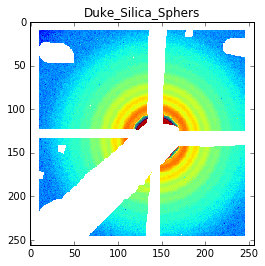

In [8]:
def test_demo(ax, inds, pix_list, img_dim, image):
    """
    This will plot the reqiured roi's on the image
    """
    tt = np.zeros(img_dim).ravel() * np.nan
    tt[pix_list] = inds

    im = ax.imshow(image, interpolation='none', norm=LogNorm())
    im = ax.imshow(tt.reshape(*img_dim), cmap='viridis', interpolation='nearest')
    
fig, ax = plt.subplots()
plt.title("Duke_Silica_Sphers")
test_demo(ax, q_inds, pixel_list, avg_img.shape, avg_img*N_mask)
plt.show()

In [6]:
inner_radius = 24  # radius of the first ring
width = 1        # width of each ring
spacing = 0      # no spacing between rings
num_rings = 5    # number of rings
center = (133, 143)   # center of the spckle pattern

#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[ 24.,  25.],
       [ 25.,  26.],
       [ 26.,  27.],
       [ 27.,  28.],
       [ 28.,  29.]])

<IPython.core.display.Javascript object>


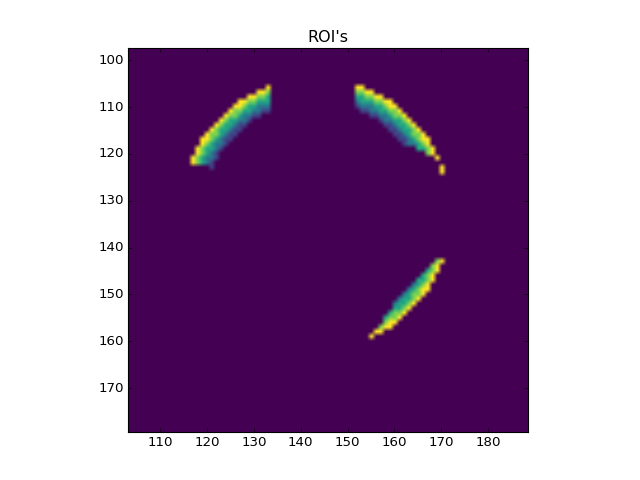

In [14]:
rings = roi.rings(edges, (133, 143), avg_img.shape)

rings_mask = rings*N_mask

# extarct the ROI's lables and pixel indices corresponding to those labels
q_inds, pixel_list = roi.extract_label_indices(rings*N_mask)

fig, ax = plt.subplots()
plt.title("ROI's")
plt.imshow(rings_mask, cmap='viridis')
plt.show()

## Two time Correlation Code

In [24]:
import numpy.ma as ma
import logging
import time

import skxray.core as core
logger = logging.getLogger(__name__)

def two_time(num_levels, num_bufs, labels, images):
    """
    This function computes two-time correlations.
    It uses a scheme to achieve long-time correlations inexpensively
    by downsampling the data, iteratively combining successive frames.
    The longest lag time computed is num_levels * num_bufs.
    ** see comments on multi_tau_auto_corr
    Parameters
    ----------
    num_levels : int
        how many generations of downsampling to perform, i.e.,
        the depth of the binomial tree of averaged frames
    num_bufs : int, must be even
        maximum lag step to compute in each generation of
        downsampling
    labels : array
        labeled array of the same shape as the image stack;
        each ROI is represented by a distinct label (i.e., integer)
    images : array
        dimensions are: (rr, cc), iterable of 2D arrays
    Returns
    -------
    two_time_c : array
        matrix of two_time correlation
        shape (number of images, number of images, number of labels(ROI))
    """

    label_mask, pixel_list, num_rois, num_pixels = _validate_inputs(num_bufs,
                                                                    labels,
                                                                    images)

    # Ring buffer, a buffer with periodic boundary conditions.
    # Images must be keep for up to maximum delay in buf.
    buf = np.zeros((num_levels, num_bufs, np.sum(num_pixels)),
                   dtype=np.float64)

    # to track processing each level
    track_level = np.zeros(num_levels)

    # to increment buffer
    cur = np.ones(num_levels, dtype=np.int64)

    # to track how many images processed in each level
    img_per_level = np.zeros(num_levels, dtype=np.int64)

    # two time correlation results
    two_time_c = np.zeros((images.operands[0].shape[0],
                           images.operands[0].shape[0], num_rois),
                          dtype=np.float64)

    # to count images in each level
    count_level = np.zeros(num_levels, dtype=np.int64)

    # generate a time frame for each level
    time_ind = {key: [] for key in range(num_levels)}

    start_time = time.time()  # used to log the computation time (optionally)
    #  for two time correlation

    tot_channels, lag_steps = utils.multi_tau_lags(num_levels, num_bufs)

    for n, img in enumerate(images.operands[0]):
        cur[0] = (1 + cur[0]) % num_bufs  # increment buffer

        count_level[0] = 1 + count_level[0]
        # current image number
        current_img_time = n + 1

        # Put the image into the ring buffer.
        buf[0, cur[0] - 1] = (np.ravel(img))[pixel_list]

        # Compute the two time correlations between the first level
        # (undownsampled) frames. two_time_c and img_per_level in place!
        _two_time_process(buf, two_time_c, label_mask, num_bufs, num_pixels,
                          img_per_level, lag_steps, current_img_time, level=0,
                          buf_no=cur[0] - 1)

        # time frame for each level
        time_ind[0].append(current_img_time)

        # check whether the number of levels is one, otherwise
        # continue processing the next level
        processing = num_levels > 1

        # Compute the correlations for all higher levels.
        level = 1
        while processing:
            if not track_level[level]:
                track_level[level] = 1
                processing = False
            else:
                prev = 1 + (cur[level - 1] - 2) % num_bufs
                cur[level] = 1 + cur[level] % num_bufs
                count_level[level] = 1 + count_level[level]

                buf[level, cur[level] - 1] = (buf[level - 1, prev - 1] +
                                              buf[level - 1,
                                                  cur[level - 1] - 1])/2

                t1_idx = (count_level[level] - 1) * 2

                current_img_time = ((time_ind[level - 1])[t1_idx]
                                    + (time_ind[level - 1])[t1_idx + 1])/2.

                # time frame for each level
                time_ind[level].append(current_img_time)

                # make the track_level zero once that level is processed
                track_level[level] = 0

                # call the _two_time_process function for each multi-tau level
                # for multi-tau levels greater than one
                # Again, this is modifying things in place. See comment
                # on previous call above.
                _two_time_process(buf, two_time_c, label_mask, num_bufs,
                                  num_pixels, img_per_level, lag_steps,
                                  current_img_time, level=level,
                                  buf_no=cur[level]-1)
                level += 1

                # Checking whether there is next level for processing
                processing = level < num_levels

    for q in range(np.max(labels)):
        x0 = two_time_c[:, :, q]
        two_time_c[:, :, q] = (np.tril(x0) + np.tril(x0).T
                               - np.diag(np.diag(x0)))

    # ending time for the two time correlation
    end_time = time.time()

    logger.info("Two Time Correlation - Processing time for {0} images took"
                " {1} seconds." .format(n, (end_time - start_time)))

    return two_time_c

def _two_time_process(buf, two_time_c, label_mask, num_bufs, num_pixels,
                      img_per_level, lag_steps, current_img_time, level,
                      buf_no):
    """
    Parameters
    ----------
    buf: array
        image data array to use for two time correlation
    two_time_c: array
        two time correlation matrix
    label_mask: array
        Elements not inside any ROI are zero; elements inside each
        ROI are 1, 2, 3, etc. corresponding to the order they are specified
        in edges and segments
    num_bufs: int, even
        number of buffers(channels)
    num_pixels : array
        number of pixels in certain roi's
        roi's, dimensions are : [number of roi's]
    img_per_level: array
        to track how many images processed in each level
    lag_steps : array
        delay or lag steps for the multiple tau analysis
        shape num_levels
    current_img_time : int
        the current image number
    level : int
        the current multi-tau level
    buf_no : int
        the current buffer number
    """
    img_per_level[level] += 1

    # in multi-tau correlation other than first level all other levels
    #  have to do the half of the correlation
    if level == 0:
        i_min = 0
    else:
        i_min = num_bufs//2

    for i in range(i_min, min(img_per_level[level], num_bufs)):
        (t_index, tmp_binned, pi_binned,
         fi_binned) = _help_process(level, num_bufs, buf_no, i, buf,
                                    label_mask)

        tind1 = (current_img_time - 1)

        tind2 = (current_img_time - lag_steps[t_index] - 1)

        if not isinstance(current_img_time, int):
            nshift = 2**(level-1)
            for i in range(-nshift+1, nshift+1):
                two_time_c[int(tind1+i),
                           int(tind2+i)] = (tmp_binned/(pi_binned *
                                                        fi_binned))*num_pixels
        else:
            two_time_c[tind1, tind2] = tmp_binned/(pi_binned *
                                                   fi_binned)*num_pixels
    return None


def _help_process(level, num_bufs, buf_no, i, buf, label_mask):
    """
    This is a helper function for both one time and two time correlation
    process functions.
    Parameters
    ----------
    level : int
        the current multi-tau level
    num_bufs : int
        number of buffers(channels)
    buf_no : int
        the current buffer number
    i : int
    buf : array
        image data array to use for two time correlation
    label_mask: array
        Elements not inside any ROI are zero; elements inside each
        ROI are 1, 2, 3, etc. corresponding to the order they are specified
        in edges and segments
    Returns
    -------
    t_index : float
        time
    tmp_binned : array
        matrix of correlation function without normalizations
    pi_binned : array
        matrix of past intensity normalizations
    fi_binned : array
        matrix of future intensity normalizations
    """
    t_index = level*num_bufs/2 + i

    delay_no = (buf_no - i) % num_bufs

    past_img = buf[level, delay_no]
    future_img = buf[level, buf_no]

    #  get the matrix of correlation function without normalizations
    tmp_binned = (np.bincount(label_mask,
                              weights=past_img*future_img)[1:])
    # get the matrix of past intensity normalizations
    pi_binned = (np.bincount(label_mask,
                             weights=past_img)[1:])

    # get the matrix of future intensity normalizations
    fi_binned = (np.bincount(label_mask,
                             weights=future_img)[1:])
    return t_index, tmp_binned, pi_binned, fi_binned


def _validate_inputs(num_bufs, labels, images):
    """
    This is a helper function to validate inputs for both one time and
    two time correlation
    Parameters
    ----------
    num_bufs : int, must be even
        maximum lag step to compute in each generation of
        downsampling
    labels : array
        labeled array of the same shape as the image stack;
        each ROI is represented by a distinct label (i.e., integer)
    images : iterable of 2D arrays
        dimensions are: (rr, cc)
    Returns
    -------
    label_mask : array
        labels of the required region of interests(ROI's)
    indices : array
        1D array of indices into the raveled image for all
        foreground pixels (labeled nonzero)
        e.g., [5, 6, 7, 8, 14, 15, 21, 22]
    num_rois : array
        number of ROI's
    num_pixels : array
        number of pixels in each ROI's
    """
    if num_bufs % 2 != 0:
        raise ValueError("number of channels(number of buffers) in "
                         "multiple-taus (must be even)")

    if labels.shape != images.operands[0].shape[1:]:
        raise ValueError("Shape of the image stack should be equal to"
                         " shape of the labels array")

    # get the pixels in each label
    label_mask, indices = roi.extract_label_indices(labels)

    num_rois = np.max(label_mask)

    # number of pixels per ROI
    num_pixels = np.bincount(label_mask, minlength=(num_rois+1))
    num_pixels = num_pixels[1:]

    if np.any(num_pixels == 0):
        raise ValueError("Number of pixels of the required roi's"
                         " cannot be zero, "
                         "num_pixels = {0}".format(num_pixels))

    return label_mask, indices, num_rois, num_pixels

In [27]:
images = N_mask*duke_data
images.shape

(5000, 256, 256)

## Get the number of levels and number of buffers and call the Two time Correlation

In [107]:
img_it = np.nditer(images)

num_levels = 20
num_bufs = 8

two_time_v= two_time(num_levels, num_bufs, rings_mask, img_it)

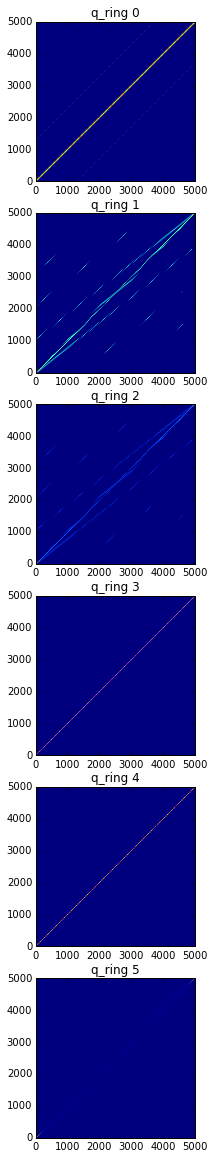

In [128]:
fig, ax = plt.subplots(num_rings, figsize=(20, 20))
for i in range(num_rings):
    ax[i].imshow(two_time_v[:, :, i], origin="lower")
    ax[i].set_title("q_ring "+str(i))
plt.show()

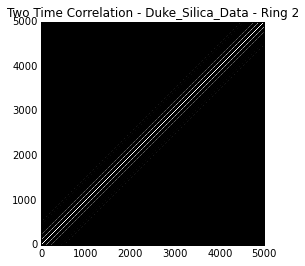

In [122]:
plt.imshow(two_time_v[:,:,3], cmap='gray',vmax='1e0', origin="lower")
plt.title("Two Time Correlation - Duke_Silica_Data - Ring 2")
plt.show()

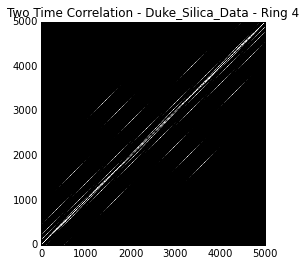

In [119]:
plt.imshow(two_time_v[:,:,5], cmap='gray', vmax='1e0', origin="lower")
plt.title("Two Time Correlation - Duke_Silica_Data - Ring 4")
plt.show()

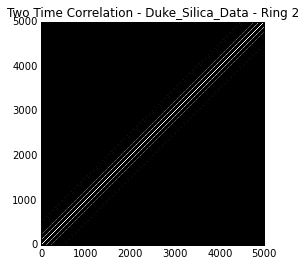

In [123]:
plt.imshow(two_time_v[:,:,1], cmap='gray', vmax='1e0', origin="lower")
plt.title("Two Time Correlation - Duke_Silica_Data - Ring 2")
plt.show()

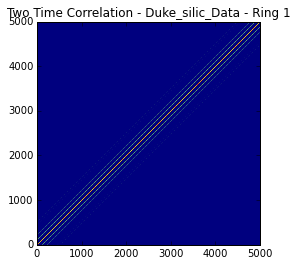

In [124]:
plt.imshow(two_time_v[:,:,0], origin="lower")
plt.title("Two Time Correlation - Duke_silic_Data - Ring 1")
plt.show()

In [99]:
two_time_c_all = two_time(1, 1000, rings_mask, img_it)

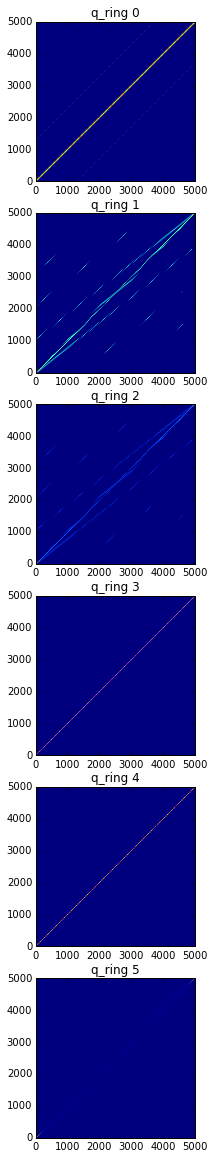

In [125]:
fig, ax = plt.subplots(num_rings, figsize=(20, 20))
for i in range(num_rings):
    ax[i].imshow(two_time_v[:, :, i], origin="lower")
    ax[i].set_title("q_ring "+str(i))
plt.show()

In [94]:
two_time_c_all.shape

(5000, 5000, 6)

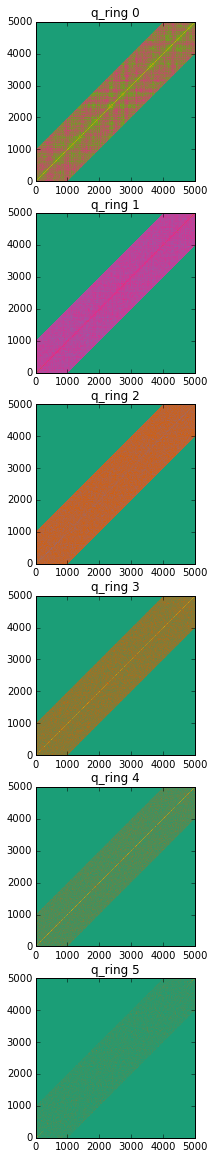

In [126]:
fig, ax = plt.subplots(num_rings, figsize=(20, 20))
for i in range(num_rings):
    ax[i].imshow(two_time_c_all[:, :, i], origin="lower", cmap="Dark2")
    ax[i].set_title("q_ring "+str(i))
plt.show()

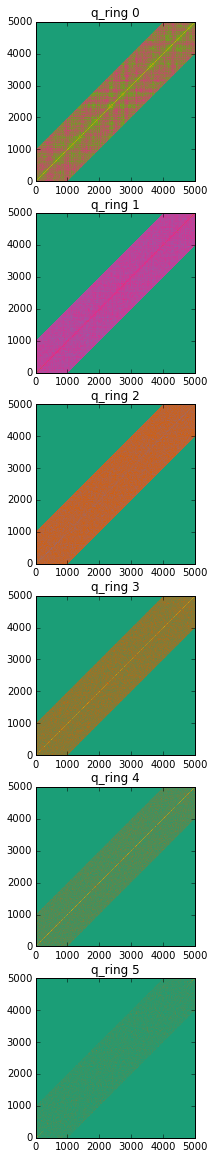

In [129]:
fig, ax = plt.subplots(num_rings, figsize=(20, 20))
for i in range(num_rings):
    ax[i].imshow(two_time_c_all[:, :, i], cmap="Dark2", origin="lower")
    ax[i].set_title("q_ring "+str(i))
plt.show()

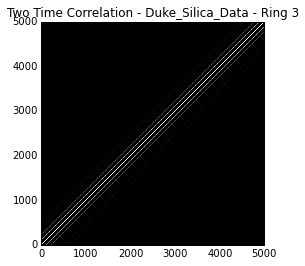

In [127]:
plt.imshow(two_time_c[:,:,2], cmap='gray', vmax='1e0', origin="lower")
plt.title("Two Time Correlation - Duke_Silica_Data - Ring 3")
plt.show()

In [64]:
from skimage import data

num_levels =19
num_bufs = 2  # must be even
coins = data.camera()
coins_stack = []

for i in range(20):
    coins_stack.append(coins)

coins_mesh = np.zeros_like(coins)
coins_mesh[coins < 30] = 1
coins_mesh[coins > 50] = 2


In [65]:
coins_it = np.nditer(np.asarray(coins_stack))
two_time_coins_n = two_time(2, 6,coins_mesh, coins_it)
two_time_coins_n.shape

(20, 20, 2)

In [66]:
two_time_coins = corr.two_time(num_levels=2, num_bufs=6,
                                   labels=coins_mesh, images=coins_stack)

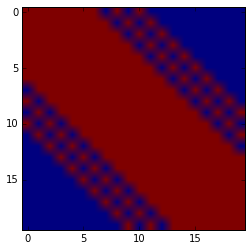

In [68]:
plt.imshow(two_time_coins_n[:,:,0])
plt.show()

In [39]:
two_time_coins.shape

(512, 512, 2)

In [48]:
np.all(two_time_coins_n[:, :, 0].diagonal(),axis=0)

True

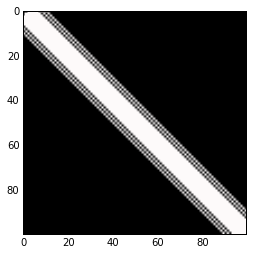

In [50]:
plt.imshow(two_time_coins_n[:, :, 1], cmap="")
plt.show()

In [88]:
num_levels = 1
num_bufs = 200 # must be even
num_qs = 2  # number of interested roi's (rings)
img_dim = (50, 50)  # detector size

roi_data = np.array(([10, 20, 12, 14], [40, 10, 9, 10]),
                        dtype=np.int64)

indices = roi.rectangles(roi_data, img_dim)

img_stack = np.random.randint(1, 5, size=(500, ) + img_dim)


In [89]:
imgit = np.nditer(img_stack)

two_time_r = two_time(num_levels,num_bufs,
                                   indices, imgit)

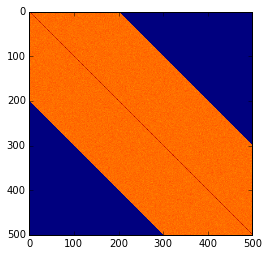

In [90]:
plt.imshow(two_time_r[:, :, 0])